# PW1 - Handwritten character recognition


In [2]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Paul-Constant TOUDRET"
assert your_name

In [124]:
%matplotlib inline
import math, sys, os, torch, torchvision
import time
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [101]:
from torchvision import datasets
from torchvision.transforms import ToTensor

root_dir = './data/MNIST/'

"""
Code taken from Torch Doc
"""

training_data = datasets.MNIST(
    root=root_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root=root_dir,
    train=False,
    download=True,
    transform=ToTensor()
)


How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

number of training example : 60000
number of test example : 10000


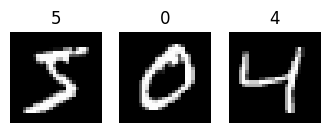

In [109]:
### Number of examples

print(f"number of training example : {len(training_data)}")
print(f"number of test example : {len(test_data)}")

### First image and label of training
"""
Code taken from Torch Doc
"""

figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 1
for i in range(0, cols * rows):
    #sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [110]:
### Dimension of the input

d, w, h = training_data[0][0].shape
print(f"dimension of image : {d}")      # Only Grey Scale
print(f"height of image : {h} pixels")
print(f"width of image : {w} pixels")


dimension of image : 1
height of image : 28 pixels
width of image : 28 pixels


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

In [111]:
### YOUR CODE HERE ###

preprocess = nn.Sequential(
    nn.AvgPool2d(
    kernel_size=4,
    stride=4
    ),
    nn.Flatten()
)
"""
Stride = 4 -> we divide the dimensions by 4 to get 7 X 7 pixels
Kernel size = 4 
"""
f_img = preprocess(training_data[0][0])

d, w, h = img.shape
print(f"dimension of image : {d}")      # Only Grey Scale
print(f"height of image : {h} pixels")
print(f"width of image : {w} pixels")

d, w = f_img.shape
print(f"dimension of flatten image : {d}")      # Only Grey Scale
print(f"width of flatten image : {w} pixels")

dimension of image : 1
height of image : 28 pixels
width of image : 28 pixels
dimension of flatten image : 1
width of flatten image : 49 pixels


In [112]:
### YOUR ( MODEL / PREPROCESSING ) CODE HERE ###
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
            super().__init__()
            
            self.input_size = input_size
            self.output_size = output_size
            
            # Second Step -> Apply only Linear layer
            self.model = nn.Linear(self.input_size, self.output_size)
            
    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        x = self.model(x)
        return x

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [113]:
import torch.optim
from torch.utils.data import DataLoader

In [114]:
### YOUR CODE HERE ###

nn1 = LinearModel(
    input_size=49,
    output_size=10
)

c_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn1.parameters(), lr=0.001, momentum=0.8)

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [115]:
# On preprocess le training_data juste pour optimiser le temps de calculs
def prep_data(preprocess, training_data, test_data):

    preprocess_train = []
    preprocess_test = []

    print(f'Preprocessing Training Set')
    for img, label in training_data:
        preprocess_train.append((preprocess(img), label))

        if len(preprocess_train) % 100 == 0 and len(preprocess_train) < len(training_data):
            print(f"Preprocess en cours : {len(preprocess_train)} of {len(training_data)}", end='\r')
        elif len(preprocess_train) == len(training_data):
            print(f"Preprocess en cours : {len(preprocess_train)} of {len(training_data)}", end='\n')


    print(f'Preprocessing Test Set')
    for img, label in test_data:
        preprocess_test.append((preprocess(img), label))

        if len(preprocess_test) % 100 == 0 and len(preprocess_test) < len(test_data):
            print(f"preprocess en cours : {len(preprocess_test)} of {len(test_data)}", end='\r')
        elif len(preprocess_test) == len(test_data):
            print(f"preprocess en cours : {len(preprocess_test)} of {len(test_data)}", end='\n')

    print(f'shape of training : {preprocess_train[0][0].shape}')
    return preprocess_train, preprocess_test

In [116]:
# On preprocess le test_data juste pour optimiser le temps de calculs

prep_train, prep_test = prep_data(
    preprocess=preprocess,
    training_data=training_data,
    test_data=test_data
    )

Preprocessing Training Set
Preprocess en cours : 60000 of 60000
Preprocessing Test Set
preprocess en cours : 10000 of 10000
shape of training : torch.Size([1, 49])


In [133]:
def train(
    model,
    epoch,
    training_data,
    optimizer,
    criterion,
    batch_size=32,
    use_flatten=True
    ):

    model.train()

    dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

    # Nombre de batch pour une époque
    n_iter = round(len(training_data) / batch_size,0) + 1

    for ep in range(epoch):
        s=time.time()
        print(f"Entering epoch n°{ep+1}")
        total_loss = 0.0
        batch = 0

        for inputs, targets in dataloader:
            if batch == 0 and ep == 0:
                print(f'inputs shape : {inputs.shape}')
            #if use_flatten:
            #    inputs = torch.flatten(inputs, start_dim=1)

            ### Ici on a envie de gérer les dimensions des inputs
            ### Directement dans les class des modèles.

            # Forward et loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            if batch == 0 and ep == 0:
                print(f'outputs shape : {outputs.shape}')

            print(f'batch {round(100*(batch+1)/n_iter,0)} %', end='\r')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch += 1
            
        avg_loss = total_loss / len(training_data)
        e = time.time()

        print(f"Epoch {ep+1}/{epoch} - Loss: {avg_loss:.4f} - {round(e-s,1)}s.")

    return optimizer, avg_loss


def test(model, test_data, cmap:str = "Blues", show_matrix: bool = False):
    model.eval()  # mode évaluation
    correct = 0
    total = len(test_data)

    dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

    batch = 0
    y_targets = []
    y_pred = []

    with torch.no_grad():  # pas de backpropagation
        for inputs, target in dataloader:
            if batch == 0:
                print(inputs.shape)

            output = model(inputs)
            if batch == 0:
                print(output.shape)

            predicted = output.argmax(dim=1).item()  # classe prédite
            batch += 1

            y_targets.append(target)
            y_pred.append(predicted)

            if predicted == target:
                correct += 1

    accuracy = correct / total

    matrix = confusion_matrix(y_true=y_targets, y_pred=y_pred)

    if show_matrix:
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
        disp.plot(cmap='Blues', xticks_rotation='vertical')
        plt.show()
    
    
    return accuracy

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [120]:
### YOUR CODE HERE ###
NUM_EPOCH = 5

nn1 = LinearModel(
    input_size = 49,
    output_size = 10
)
optimizer = torch.optim.SGD(nn1.parameters(), lr=0.01, momentum=0.9)

pot, loss = train(
    model=nn1,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=prep_train,
    optimizer=optimizer,
    batch_size=50,
    use_flatten=True
    )

Entering epoch n°1
inputs shape : torch.Size([50, 1, 49])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0258
Entering epoch n°2
Epoch 2/5 - Loss: 0.0154
Entering epoch n°3
Epoch 3/5 - Loss: 0.0130
Entering epoch n°4
Epoch 4/5 - Loss: 0.0119
Entering epoch n°5
Epoch 5/5 - Loss: 0.0112


torch.Size([1, 1, 49])
torch.Size([1, 10])


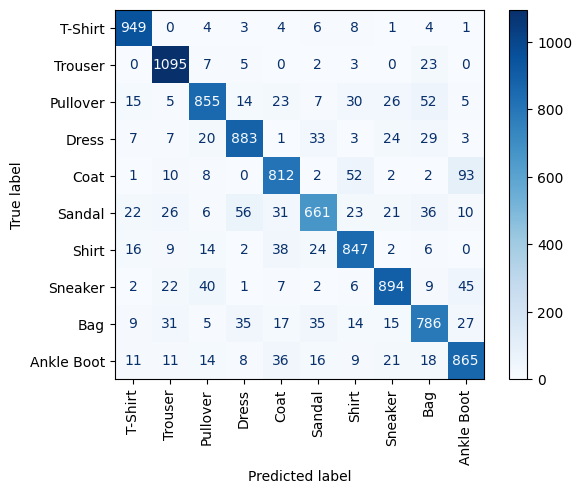

0.8647


In [122]:
accuracy = test(
    model = nn1,
    test_data=prep_test,
    show_matrix = True
)
print(accuracy)

## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [69]:

class MLP(nn.Module):
    def __init__(self, input_size, output_size, width, depth):
        super().__init__()

        layers = []

        # Première couche : input -> hidden
        layers.append(nn.Linear(input_size, width))
        layers.append(nn.ReLU())

        # Couches intermédiaires : hidden -> hidden (depth - 1 fois)
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())

        # Dernière couche : hidden -> output
        layers.append(nn.Linear(width, output_size))

        # Assemblage du réseau
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # s'assurer que l'entrée est de forme (batch, input_size)
        return self.model(x)


In [130]:
mlp1 = MLP(
    input_size= 49,
    output_size= 10,
    width= 100,
    depth=3
)
NUM_EPOCH = 5

optimizer = torch.optim.SGD(mlp1.parameters(), lr=0.01, momentum=0.9)

train(
    model=mlp1,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=prep_train,
    optimizer=optimizer,
    batch_size=50,
    use_flatten=True
    )

Entering epoch n°1
inputs shape : torch.Size([50, 1, 49])
outputs shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0223 - 9.2s.
Entering epoch n°2
Epoch 2/5 - Loss: 0.0072 - 9.1s.
Entering epoch n°3
Epoch 3/5 - Loss: 0.0050 - 8.5s.
Entering epoch n°4
Epoch 4/5 - Loss: 0.0041 - 8.7s.
Entering epoch n°5
Epoch 5/5 - Loss: 0.0036 - 9.1s.


(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 0.0036281813132887086)

torch.Size([1, 1, 49])
torch.Size([1, 10])


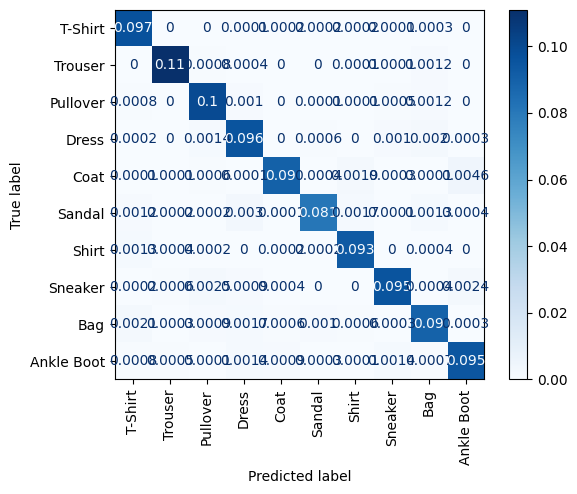

0.9466


In [132]:
accuracy = test(
    model = mlp1,
    test_data=prep_test,
    show_matrix=True
)
print(accuracy)

# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [74]:
# On preprocess le training_data juste pour optimiser le temps de calculs
# Ici on garde les tensor de dim 28 X 28

preprocess = nn.AvgPool2d(kernel_size=1,stride=1)

conv_train, conv_test = prep_data(
    preprocess=preprocess,
    training_data=training_data,
    test_data=test_data
)


Preprocessing Training Set
Preprocess en cours : 60000 of 60000
Preprocessing Test Set
preprocess en cours : 10000 of 10000
shape of training : torch.Size([1, 28, 28])


In [75]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Linear(8 * 13 * 13, 10)  # Flatten + Linear

    def forward(self, x):
        x = self.conv(x)               # (batch, 1, 28, 28) -> (batch, 8, 13, 13)
        x = x.view(x.size(0), -1)      # Flatten
        x = self.classifier(x)         # (batch, 1352) -> (batch, 10)
        return x

In [76]:
conv = ConvModel()

NUM_EPOCH = 5

train(
    model=conv,
    epoch=NUM_EPOCH,
    criterion=nn.CrossEntropyLoss(),
    training_data=conv_train,
    optimizer=torch.optim.SGD(conv.parameters(), lr=0.01, momentum=0.9),
    batch_size=50,
    use_flatten=False
    )


Entering epoch n°1
inputs shape : torch.Size([50, 1, 28, 28])
outours shape : torch.Size([50, 10])
Epoch 1/5 - Loss: 0.0108
Entering epoch n°2
Epoch 2/5 - Loss: 0.0078
Entering epoch n°3
Epoch 3/5 - Loss: 0.0071
Entering epoch n°4
Epoch 4/5 - Loss: 0.0067
Entering epoch n°5
Epoch 5/5 - Loss: 0.0064


(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 0.006411130461469293)

torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


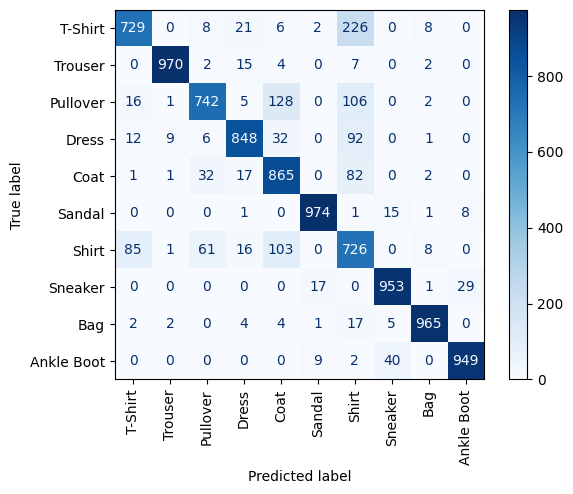

0.8721


In [97]:

accuracy = test(
    model = conv,
    test_data=conv_test,
    show_matrix=True
)
print(accuracy)

You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [62]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
       
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),  # (28x28) -> (26x26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # (26x26) -> (13x13)
        )

        # Linear layer après flatten
        self.classifier = nn.Linear(8 * 13 * 13, 10)  # 10 classes


    def forward(self,x):
        ### YOUR CODE HERE ###
        x = self.conv(x)                 # Conv -> ReLU -> MaxPool
        x = x.view(x.size(0), -1)        # Flatten
        x = self.classifier(x)           # Linear
        return x

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

In [ ]:
conv = ConvDeepModel()

optimizer = torch.optim.SGD(conv.parameters(), lr=0.01, momentum=0.9)

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        ### YOUR CODE HERE ###

    def forward(self,x):
        ### YOUR CODE HERE ###
        pass

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [ ]:
class ResidualModel(torch.nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super(ResidualModel, self).__init__()
        ### YOUR CODE HERE ###

    def forward(self,x):
        ### YOUR CODE HERE ###
        pass

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [ ]:
### YOUR CODE HERE ###

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [ ]:
def ce(logits, targets):
    ### YOUR CODE HERE ###
    pass

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [ ]:
### YOUR CODE HERE ###

Re-implement a stable version of cross-entropy.

In [ ]:
def stable_ce(logits, targets):
    ### YOUR CODE HERE ###
    pass